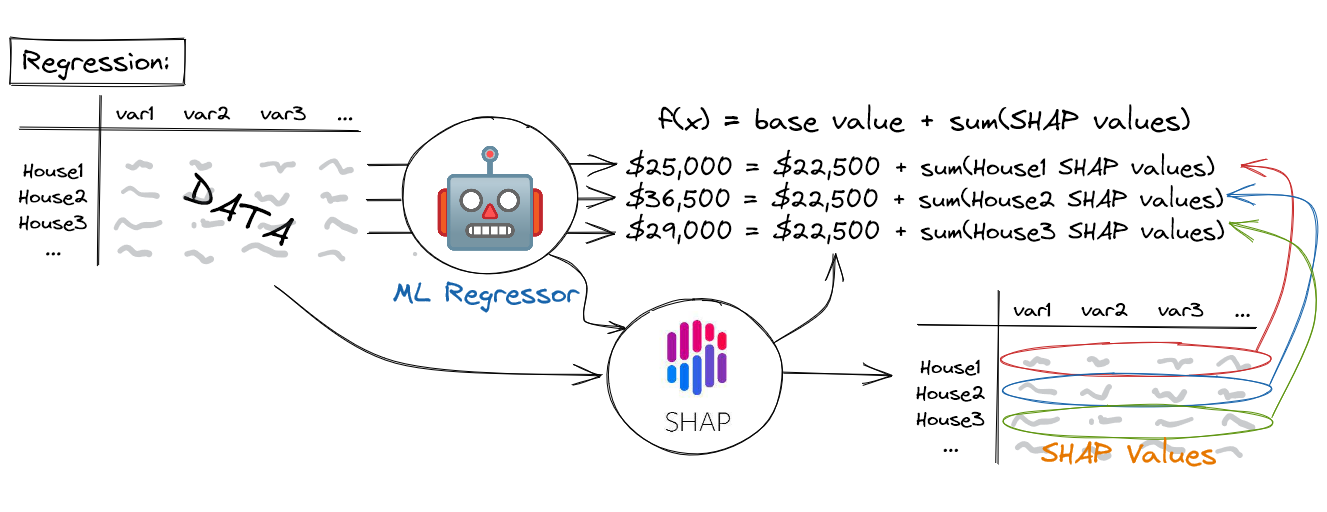!

Pic Credit: Aiden Cooper

# Introduction to SHAP

Suppose you have a dataset with information about patients, including their age, BMI, blood pressure, and other health metrics, as well as whether or not they have been diagnosed with diabetes. You want to build a machine learning model that can predict whether or not a new patient will have diabetes, based on their health metrics.

To help you understand how your model is making these predictions, you can use SHAP to compute feature importance scores. These scores can tell you which health metrics are most important for predicting diabetes, and how they contribute to each individual prediction.

SHAP uses a technique called Shapley values to compute feature importance scores. These values are based on game theory, and provide a way to fairly distribute the contribution of each feature to a given prediction. SHAP can compute Shapley values for any machine learning model that can predict a numerical output, including classifiers like Random Forests, Decision Trees, and Neural Networks.

To use SHAP to explain your diabetes prediction model, you can start by loading your model and data into a SHAP explainer object. This will allow you to compute Shapley values for individual predictions and visualize how each feature contributes to the prediction.

Overall, SHAP is a powerful tool for interpreting machine learning models and understanding how they make their predictions. By using Shapley values to attribute feature importance, SHAP can provide valuable insights into the inner workings of complex models, such as those used for predicting diabetes.

**In the below slide you will get an idea how we can leverage power of SHAP to unterpret black box model on multiclass classification dataset**

# Loading Required Libraries

In [1]:
#LOADING REQUIRED LIBRARIES
#Data Visualization libraries
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

#Encoders
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Importing train, test split library
from sklearn.model_selection import train_test_split

#Metrices import
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, roc_curve, make_scorer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectFromModel
from numpy import sort

#Accuracy Check
from sklearn.model_selection import cross_val_score

#Importing custom packages
from sklearn.base import TransformerMixin

# Importing ML Model packages
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Hyperopt
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope

#For proper display of all columns
from IPython.display import display
pd.options.display.max_columns = None

#Import warnings
import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Optuna
import xgboost as xgb
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.disable_default_handler()

from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time
from sklearn.metrics import plot_confusion_matrix

# Shaply
import shap

#pickle
import pickle

#LGBM Model
import lightgbm as lgb

# Undersampling
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model-xgb/model.pkl
/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv


In [2]:
loading_saved_model = True

# Writing some utility function

In [3]:
# Imputing the remaining missing variables
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """
        Impute missing values.

        Columns of dtype object are imputed with the most frequent value
        in column.

        Columns of other types are imputed with mean of column.

        """

    def fit(self, A, b=None):

        self.fill = pd.Series(
            [
                A[c].value_counts().index[0]
                if A[c].dtype == np.dtype("O")
                else A[c].mean()
                for c in A
            ],
            index=A.columns,
        )

        return self

    def transform(self, A, b=None):
        return A.fillna(self.fill)
    
# Funtion to check the missing value count and percentage   
def missing_val_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data

def onehotdataframe(data, cat_cols):
    """
    Creates dummy features for categorical data.
    """
    for c in cat_cols:
        one_hot_col = pd.get_dummies(data[c])
        one_hot_col.columns = [str(col) + "_" + c for col in one_hot_col.columns]
        data = data.drop(c, axis=1)

        # Merging one hot encoded features with our dataset 'data'
        data = pd.concat([data, one_hot_col], axis=1)

    return data

# Creating a funtion to print model performance report on validation and test
def gen_class_report(model, model_name, X_val, y_val, X_test, y_test, val_skip):
    """
    Build a classication model performance report.
    val_skip = True implies skipping performance check on validation and performing check only on test.
    val_skip = False implies checking performance on both validation and test set
    """
    if val_skip == False:
        y_pred_val = model.predict(X_val)
        print(
            "Classification Report for {} model on validation set\n".format(model_name)
        )
        print(classification_report(y_val, y_pred_val))
        print(
            "\n accuracy: {} & F1_Score: {} \n".format(
                accuracy_score(y_val, y_pred_val), f1_score(y_val, y_pred_val, average='macro')
            )
        )
        cm_val = confusion_matrix(y_val, y_pred_val)

        print(
            "Classification Report for {} model on hold out test set\n".format(
                model_name
            )
        )
        y_pred_test = model.predict(X_test)
        print(classification_report(y_test, y_pred_test))
        print(
            "\n accuracy: {} & F1_Score: {} \n".format(
                accuracy_score(y_test, y_pred_test), f1_score(y_test, y_pred_test, average='macro')
            )
        )
        cm_test = confusion_matrix(y_test, y_pred_test)
        print("Confusion matrix on test set : \n")
        sns.heatmap(cm_test, annot=True, fmt="d", cbar=False)
        return cm_val, cm_test
    else:
        print(
            "Classification Report for {} model on hold out test set\n".format(
                model_name
            )
        )
        y_pred_test = model.predict(X_test)
        print(classification_report(y_test, y_pred_test))
        print(
            "\n accuracy: {} & F1_Score: {} \n".format(
                accuracy_score(y_test, y_pred_test), f1_score(y_test, y_pred_test, average='macro')
            )
        )
        cm_test = confusion_matrix(y_test, y_pred_test)
        print("Confusion matrix on test set : \n")
        sns.heatmap(cm_test, annot=True, fmt="d", cbar=False)
        return "", cm_test
    
def get_feat_imp_plot(model, X):
    """
    input::model - A fitted trained model to plot the feature importance plot
    """
    # X and y were the full training data before splitting the data further in validation. Refer above
    features = list(X.columns)
    try:
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)

        plt.figure(figsize=(15, 20))
        plt.title("Feature Importances")
        plt.barh(range(len(indices)), importances[indices], color="b", align="center")
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel("Relative Importance")
        plt.show()
        return indices, importances
    except Exception as error:
        print('Model Doesnt Support feature importance calculations :' + repr(error))

# Load the Data

In [4]:
# Load the data
diab = pd.read_csv("/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv")

diab.head()

Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                   0.0           0.0     0.0      1.0                0.0   
1                   0.0           1.0     0.0      0.0                0.0   
2                   0.0           0.0     1.0      0.0                0.0   
3                   0.0           1.0     1.0      1.0                0.0   
4                   0.0           1.0     1.0      1.0                0.0   

   AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  \
0            1.0          0.0      5.0      18.0      15.0       1.0  0.0   
1            0.0          1.0      3.0       0.0       0.0       0.0  0.0   
2            1.0          1.0      5.0      30.0      30.0       1.0  0.0   
3            1.0          0.0      2.0       0.0       0.0       0.0  0.0   
4            1.0          0.0      2.0       3.0       0.0       0.0  0.0   

    Age  Education  Income  
0   9.0        4.0     3.0  
1   7.0        6.0     1.0  
2   9.0        4.0     8.0  
3  11.0        3.0     6.0  
4  11.0        5.0     4.0

In [5]:
diab.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [6]:
diab.shape

(253680, 22)

# Data Dictionary:

- Diabetes_012: Target variable indicating whether the respondent has diabetes (2), pre-diabetes (1), or no diabetes (0)
- HighBP: Binary variable indicating whether the respondent has high blood pressure (1) or not (0)
- HighChol: Binary variable indicating whether the respondent has high cholesterol (1) or not (0)
- CholCheck: Binary variable indicating whether the respondent has had their cholesterol checked in the past year (1) or not (0)
- BMI: Body mass index of the respondent, calculated as weight in kilograms divided by height in meters squared
- Smoker: Binary variable indicating whether the respondent is a current smoker (1) or not (0)
- Stroke: Binary variable indicating whether the respondent has had a stroke (1) or not (0)
- HeartDiseaseorAttack: Binary variable indicating whether the respondent has had heart disease or a heart attack (1) or not (0)
- PhysActivity: Binary variable indicating whether the respondent engages in regular physical activity (1) or not (0)
- Fruits: Consume Fruit 1 or more times per day 0 = no 1 = yes
- Veggies: Consume Vegetables 1 or more times per day 0 = no 1 = yes
- HvyAlcoholConsump: Binary variable indicating whether the respondent engages in heavy alcohol consumption (1) or not (0)
- AnyHealthcare: Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes
- NoDocbcCost: Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes
- GenHlth: Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor
- MentHlth: Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good?
- PhysHlth: Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good?
- DiffWalk: Binary variable indicating whether the respondent has difficulty walking (1) or not (0)
- Sex: Binary variable indicating the gender of the respondent (1 for male, 0 for female)
- Age: 13-level age category 1 = 18-24 9 = 60-64 13 = 80 or older
- Education: Level of education attained by the respondent (1 for less than high school, 2 for high school or equivalent, 3 for some college, and 4 for college graduate or higher)
- Income: Annual household income of the respondent, reported in US dollars

In [7]:
print(diab.dtypes)
print("\n Below is the shape of the data: \n", diab.shape)

Diabetes_012            float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

 Below is the shape of the data: 
 (253680, 22)


# Quick Data Cleaning

**Missing Value Check**

In [8]:
# Converting blank spaces to null to capture the duplicates from our data
#diab.replace(r"^\s*$", np.nan, regex=True, inplace=True)
missing_val_check(diab)

if missing_val_check(diab)['Total'].sum() == 0:
    print("No Missing Value found")

No Missing Value found


**Duplicates check**

In [9]:
duplicates = diab[diab.duplicated()]
print("Total Duplicates rows observed:", duplicates.shape[0])
print("Dropping duplicates - If each field is exactly same as this wont add any value to the model")

# Dropping duplicates
print("Shape before dropping duplicates : ", diab.shape[0])
diab.drop_duplicates(inplace = True)
print("Shape after dropping duplicates : ", diab.shape[0])

Total Duplicates rows observed: 23899
Dropping duplicates - If each field is exactly same as this wont add any value to the model
Shape before dropping duplicates :  253680
Shape after dropping duplicates :  229781


In [10]:
diab.shape

(229781, 22)

# Quick Data Stats

In [11]:
# Lets see the data statistics
diab.describe(percentiles=[0.1, 0.25, 0.75, 0.9, 0.95])

Diabetes_012         HighBP       HighChol      CholCheck  \
count  229781.000000  229781.000000  229781.000000  229781.000000   
mean        0.325627       0.454441       0.441760       0.959535   
std         0.724623       0.497921       0.496598       0.197047   
min         0.000000       0.000000       0.000000       0.000000   
10%         0.000000       0.000000       0.000000       1.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       1.000000       1.000000       1.000000   
90%         2.000000       1.000000       1.000000       1.000000   
95%         2.000000       1.000000       1.000000       1.000000   
max         2.000000       1.000000       1.000000       1.000000   

                BMI         Smoker         Stroke  HeartDiseaseorAttack  \
count  229781.00000  229781.000000  229781.000000         229781.000000   
mean       28.68567       0.465661       0.044756              0.103216   
std         6.78636       0.498821       0.206767              0.304241   
min        12.00000       0.000000       0.000000              0.000000   
10%        22.00000       0.000000       0.000000              0.000000   
25%        24.00000       0.000000       0.000000              0.000000   
50%        27.00000       0.000000       0.000000              0.000000   
75%        32.00000       1.000000       0.000000              0.000000   
90%        37.00000       1.000000       0.000000              1.000000   
95%        40.00000       1.000000       0.000000              1.000000   
max        98.00000       1.000000       1.000000              1.000000   

        PhysActivity         Fruits        Veggies  HvyAlcoholConsump  \
count  229781.000000  229781.000000  229781.000000      229781.000000   
mean        0.733355       0.612966       0.794813           0.060710   
std         0.442206       0.487073       0.403839           0.238798   
min         0.000000       0.000000       0.000000           0.000000   
10%         0.000000       0.000000       0.000000           0.000000   
25%         0.000000       0.000000       1.000000           0.000000   
50%         1.000000       1.000000       1.000000           0.000000   
75%         1.000000       1.000000       1.000000           0.000000   
90%         1.000000       1.000000       1.000000           0.000000   
95%         1.000000       1.000000       1.000000           1.000000   
max         1.000000       1.000000       1.000000           1.000000   

       AnyHealthcare    NoDocbcCost        GenHlth       MentHlth  \
count  229781.000000  229781.000000  229781.000000  229781.000000   
mean        0.946075       0.092810       2.601151       3.505373   
std         0.225871       0.290167       1.064685       7.713725   
min         0.000000       0.000000       1.000000       0.000000   
10%         1.000000       0.000000       1.000000       0.000000   
25%         1.000000       0.000000       2.000000       0.000000   
50%         1.000000       0.000000       3.000000       0.000000   
75%         1.000000       0.000000       3.000000       2.000000   
90%         1.000000       0.000000       4.000000      15.000000   
95%         1.000000       1.000000       5.000000      30.000000   
max         1.000000       1.000000       5.000000      30.000000   

            PhysHlth       DiffWalk            Sex            Age  \
count  229781.000000  229781.000000  229781.000000  229781.000000   
mean        4.675178       0.185507       0.439231       8.086582   
std         9.046568       0.388709       0.496295       3.093809   
min         0.000000       0.000000       0.000000       1.000000   
10%         0.000000       0.000000       0.000000       4.000000   
25%         0.000000       0.000000       0.000000       6.000000   
50%         0.000000       0.000000       0.000000       8.000000   
75%         4.000000

**Key Highlights**

- We cant find anything suspicious at first look from data description.
- Roughly 25% of the population in this dataset has highBP and cholestrol
- Roughly 50% of the population in this dataset is non smoker
- 90 percentile of the population has not encountered heart attach in the past
- More than 75 percentile population engages in physical activites
- More than 50% of the population eats fruits and vegetables everyday. 
- Roughly 5% of the population heavy alcohol consumer.
- Less than 10% of the population doesnt hold any healthcare.
- 75% of the population have reported excellent to good general health.
- Close to 75% of the population have reported that we physically, mentally ill less than 2-3 days during past 30 days.
- Roughly 10% of the people reported difficulty in walking
- Less than 5% of the population reported stroke while roughly 5% of the population reported heart disease or Attack in thee past
- It seems we have 50-50 split of males and females, which we can double check.

In [12]:
# Lets see the data statistics
try:
    diab.describe(include = ['O'])
except:
    print("Can't describe categorical data as no categorical feature present in the dataset")

Can't describe categorical data as no categorical feature present in the dataset


<AxesSubplot:xlabel='Diabetes_012', ylabel='count'>

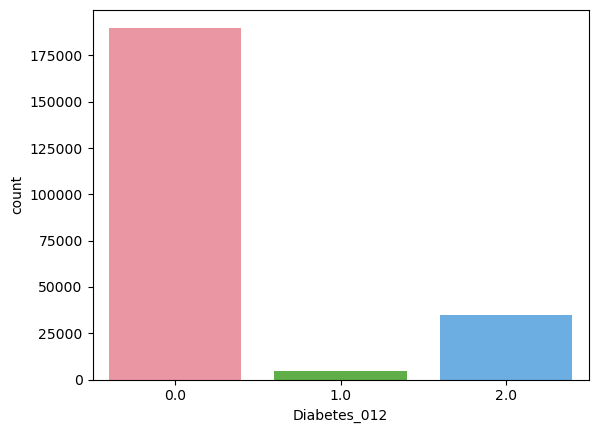

In [13]:
# Set consistent color palette

# Create a custom sequential color palette
palette = sns.color_palette("RdYlGn", n_colors=2)[::-1]

sns.set_palette(palette)

# Explore distribution of target variable
sns.countplot(x='Diabetes_012', data=diab)

In [14]:
discrete_var = ['HighBP','HighChol','CholCheck','Smoker','Stroke',
                'HeartDiseaseorAttack', 'Age', 'Sex','Education','Income', 
                'PhysActivity','Fruits', 'Veggies', 'HvyAlcoholConsump',
                'AnyHealthcare', 'NoDocbcCost','GenHlth', 'MentHlth', 
                'PhysHlth', 'DiffWalk']
#sns.countplot(x= 'Age', hue="Diabetes_012", data= diab)

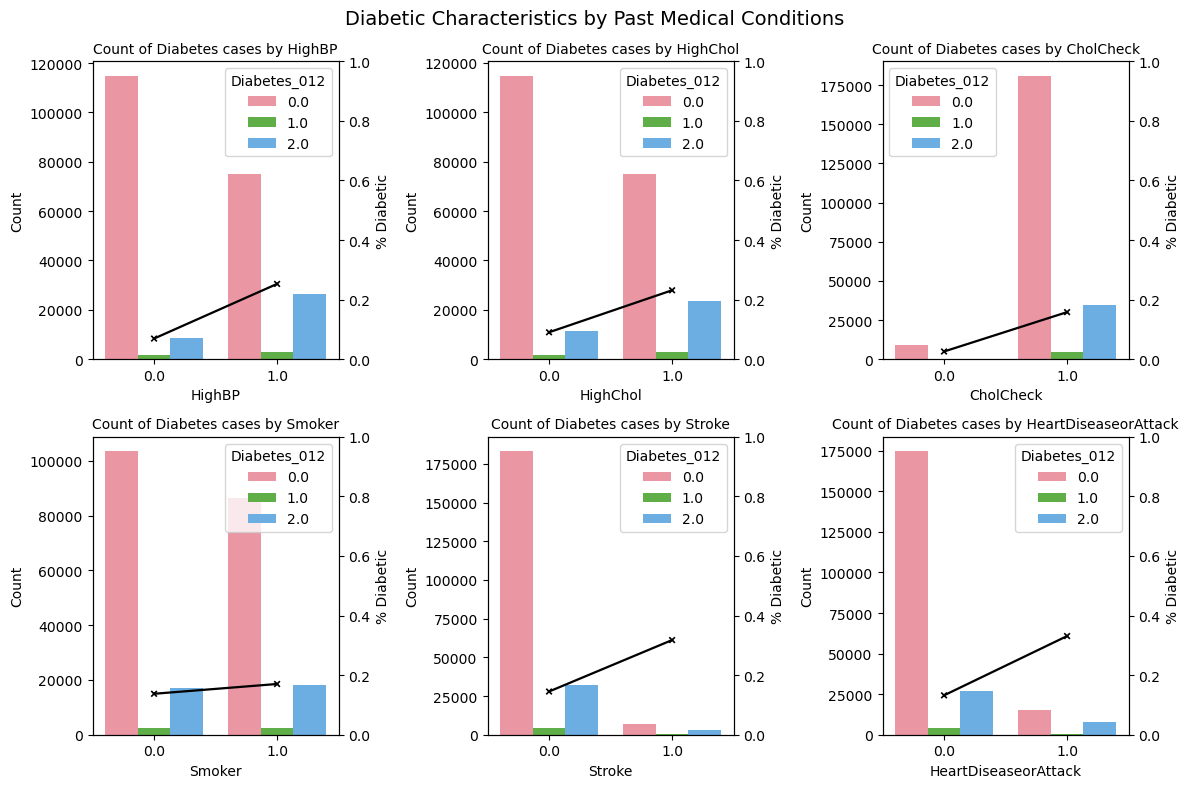

In [15]:
# create a new column with binary indicator variable for Diabetes_012
diab["Diabetes_binary"] = diab["Diabetes_012"].apply(lambda x: 1 if x == 2 else 0)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Diabetic Characteristics by Past Medical Conditions", fontsize=14)
for i, var in enumerate(discrete_var[0:6]):
    ax = axes[i//3][i%3]
    sns.countplot(x=var, hue="Diabetes_012", data=diab, ax=ax)
    ax.set_xlabel(var)
    ax.set_ylabel("Count")
    ax.set_title("Count of Diabetes cases by "+var,fontdict={"fontsize": 10})
    ax2=ax.twinx()
    ax2 = sns.pointplot(x=var, y="Diabetes_binary", data=diab.groupby(var).mean().reset_index(),color='black',markers='x',scale=0.6, ax=ax2)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel("% Diabetic", color='black')
plt.tight_layout()
plt.show()


**Key Insights:**

- We can clearly see rise of diabetic risk in people who have high BP, High Col.
- Smokers have higer risk of Diabetes
- History of stroke and heart diseases possess greater risk to being diabetic as per data


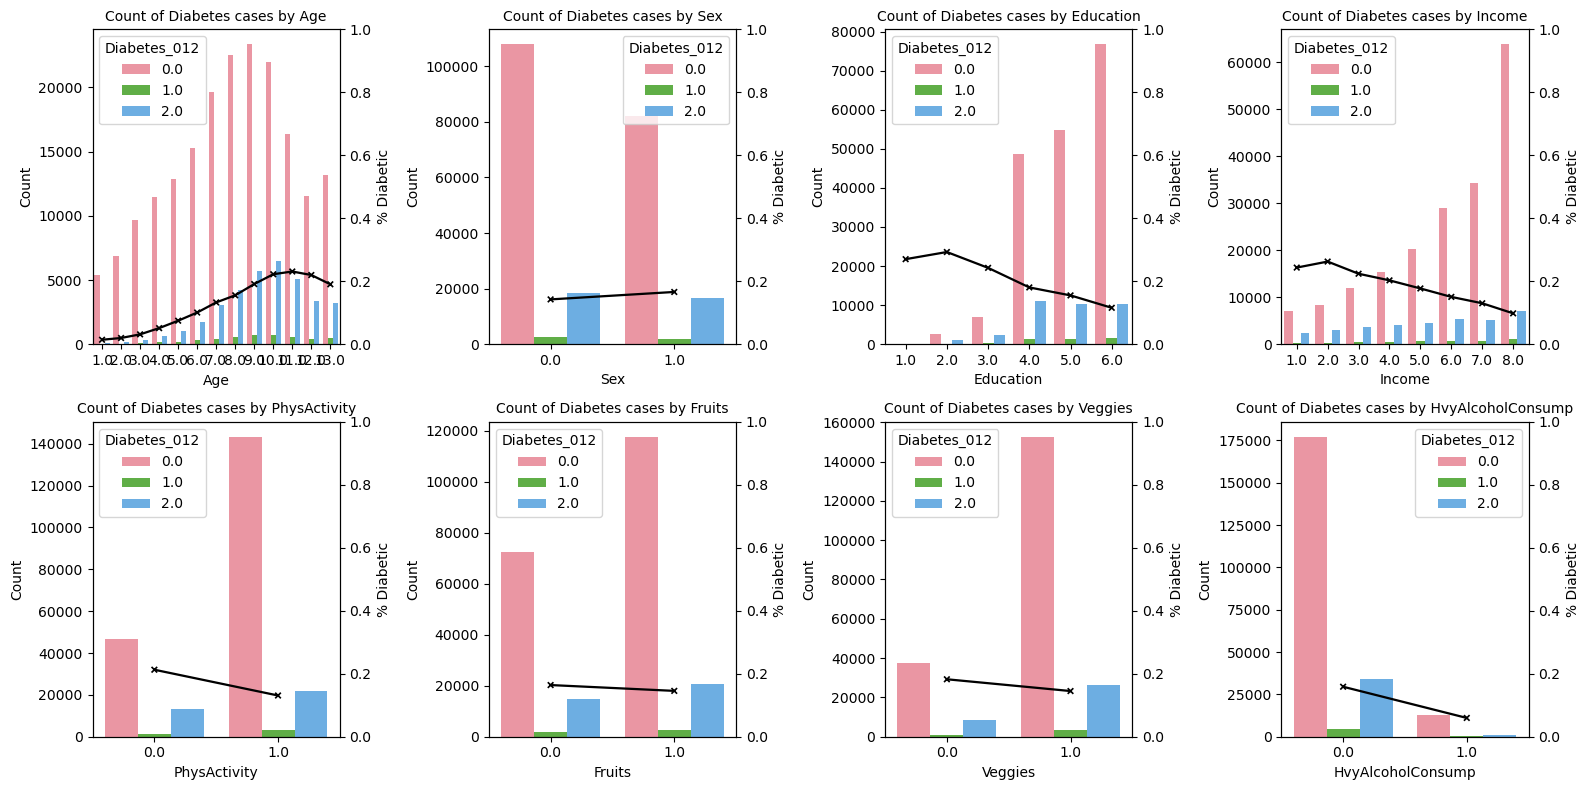

In [16]:
fig.suptitle("Diabetic Characteristics by Past Medical Conditions", fontsize=14)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, var in enumerate(discrete_var[6:14]):
    ax = axes[i//4][i%4]
    sns.countplot(x=var, hue="Diabetes_012", data=diab, ax=ax)
    ax.set_xlabel(var)
    ax.set_ylabel("Count")
    ax.set_title("Count of Diabetes cases by "+var,fontdict={"fontsize": 10})
    ax2=ax.twinx()
    ax2 = sns.pointplot(x=var, y="Diabetes_binary", data=diab.groupby(var).mean().reset_index(),color='black',markers='x',scale=0.6, ax=ax2)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel("% Diabetic", color='black')
plt.tight_layout()
plt.show()

**Key Insights:**

- Data tells that increasing age have higher risk of diabetes.
- Males are found to possess slightly higher risk of diabetes.
- People with higher education, income are found to be on lower risk
- People who are physically active, eats fruits veggies everyday are found to be on lower risk according to data. 

In [17]:
diab_train = diab.copy().drop("Diabetes_binary", axis = 1)

In [18]:
# Split the data into training and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(diab_train.drop('Diabetes_012', axis=1), 
                                                    diab['Diabetes_012'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=diab["Diabetes_012"])

X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                  y_train_val, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y_train_val)

In [19]:
print("Percent Class Distribution - Train")
print(y_train.value_counts())
print("\nPercent Class Distribution - Train (% Split)")
print(y_train.value_counts(normalize= True)*100)
print("="*10)
print("\nPercent Class Distribution - Validation")
print(y_val.value_counts())
print("\nPercent Class Distribution - Validation (% Split)")
print(y_val.value_counts(normalize= True)*100)
print("="*10)
print("Percent Class Distribution - Test")
print(y_test.value_counts())
print("\nPercent Class Distribution - Test (% Split)")
print(y_test.value_counts(normalize= True)*100)

Percent Class Distribution - Train
0.0    121634
2.0     22462
1.0      2963
Name: Diabetes_012, dtype: int64

Percent Class Distribution - Train (% Split)
0.0    82.711021
2.0    15.274142
1.0     2.014838
Name: Diabetes_012, dtype: float64

Percent Class Distribution - Validation
0.0    30409
2.0     5616
1.0      740
Name: Diabetes_012, dtype: int64

Percent Class Distribution - Validation (% Split)
0.0    82.711818
2.0    15.275398
1.0     2.012784
Name: Diabetes_012, dtype: float64
Percent Class Distribution - Test
0.0    38012
2.0     7019
1.0      926
Name: Diabetes_012, dtype: int64

Percent Class Distribution - Test (% Split)
0.0    82.712100
2.0    15.272973
1.0     2.014927
Name: Diabetes_012, dtype: float64


# Modelling

**Tune Model & Fit Tuned Model**

In [21]:
if loading_saved_model == False:
    # define objective function for Optuna
    def objective(trial):
        params = {
            "objective": "multi:softmax",
            'verbosity': 0,
            "num_class": 3,
            "eval_metric": "mlogloss",
            "tree_method": "gpu_hist",
            "booster": "gbtree",
            "random_state" : 50,
            "max_depth": trial.suggest_int("max_depth", 1, 9),
            "subsample": trial.suggest_float("subsample", 0.1, 1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0.01, 1),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10),
            "n_estimators": trial.suggest_int("n_estimators", 50, 3000, step=50),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
            "grow_policy": trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
        }

        # use StratifiedKFold cross-validation with 5 folds
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

        # define F1 score as evaluation metric
        score = make_scorer(f1_score, average='macro')

        start_time = time.time()

        # perform cross-validation and calculate F1 score
        clf = xgb.XGBClassifier(**params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        f1_score_val = f1_score(y_val, y_pred, average='macro')

        elapsed_time = time.time() - start_time

        # return mean F1 score and elapsed time
        return f1_score_val

    # create study object and optimize objective function
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50,show_progress_bar=True)

    # print best hyperparameters and best F1 score
    print("Best hyperparameters: ", study.best_params)
    print("Best F1 score: ", study.best_value)
    
    # Performance on test set and Overfitting check
    model = xgb.XGBClassifier( objective = "multi:softmax",
                             random_state=50,
                             verbosity =  0,
                             num_class = 3,
                             eval_metric = "mlogloss",
                             tree_method = "gpu_hist",
                             booster = "gbtree", **study.best_params)
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='macro')

    print("Validation F1-Score", study.best_value)
    print("Test F1-Score", f1_score_test)
    print("Difference between performance of Validation and test", abs(f1_score_test - study.best_value))
    print(f"Is the Model Overfitting : {abs((f1_score_test - study.best_value))/ study.best_value > 0.05}")

In [22]:
if loading_saved_model == False:
    gen_class_report(model,"XGboost",X_val,y_val,X_test, y_test,val_skip = False)

In [23]:
if loading_saved_model == False:
    # Refit on full train set - old train + val
    model = xgb.XGBClassifier( objective = "multi:softmax",
             random_state = 1000,
             verbosity =  0,
             num_class = 3,
             eval_metric = "mlogloss",
             tree_method = "gpu_hist",
             booster = "gbtree", **study.best_params)
    model.fit(X_train_val, y_train_val)

In [24]:
if loading_saved_model == False:
    y_pred_test = model.predict(X_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='macro')

    print("Validation F1-Score", study.best_value)
    print("Test F1-Score", f1_score_test)
    print("Difference between performance of Validation and test", abs(f1_score_test - study.best_value))
    print(f"Is the Model Overfitting : {abs((f1_score_test - study.best_value))/ study.best_value > 0.05}")
else:
    print("Reading Saved model & Training..")
    with open('/kaggle/input/model-xgb/model.pkl', 'rb') as file:
        model = pickle.load(file)
        model.fit(X_train_val, y_train_val)
        y_pred_test = model.predict(X_test)

Reading Saved model & Training..


Classification Report for XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6252860741845615, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              gamma=0.3938982460442397, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2447187188569616, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=1750, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', random_state=1000, ...) model on hold out test set

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90     38012
         1.0       0.07      0.01      0.01       926
       

('',
 array([[36089,    36,  1887],
        [  775,     5,   146],
        [ 5331,    31,  1657]]))

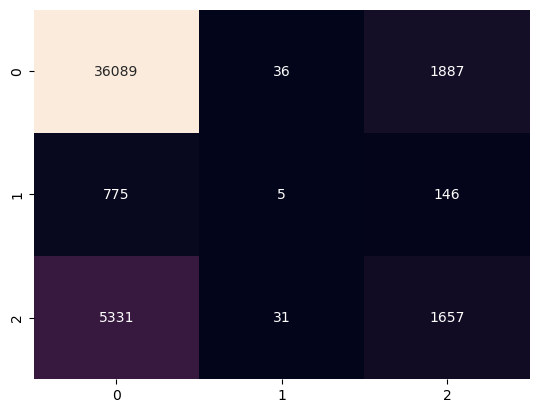

In [25]:
gen_class_report(model,model,"","",X_test, y_test,val_skip = True)

In [26]:
# import pickle

# with open('model.pkl', 'wb') as file:
#     pickle.dump(model, file)

# SHAP

**What is SHAP and Why it is too powerful**

- SHAP (SHapley Additive exPlanations) is a framework for interpreting the output of machine learning models. It provides a way to attribute the output of a model to its individual features, in order to understand how each feature contributes to the model's prediction.

- The SHAP framework is based on the concept of Shapley values, which come from cooperative game theory. In this context, Shapley values are a way to fairly distribute the payoff of a game among its players. In the context of machine learning, the "game" is the prediction task, and the "players" are the individual features of the input data.

- The formula for calculating SHAP values for classification depends on the specific algorithm being used. However, the general idea is to compute the difference between the model's output for a given data point and the average output for all possible subsets of features that include that data point's features. This difference is then multiplied by the number of possible feature subsets that include the given features, and averaged over all possible feature subsets.

- SHAP assigns each feature an importance value for a particular prediction. Its novel components include: (1) the identification of a new class of additive feature importance measures, and (2) theoretical results showing there is a unique solution in this class with a set of desirable properties.

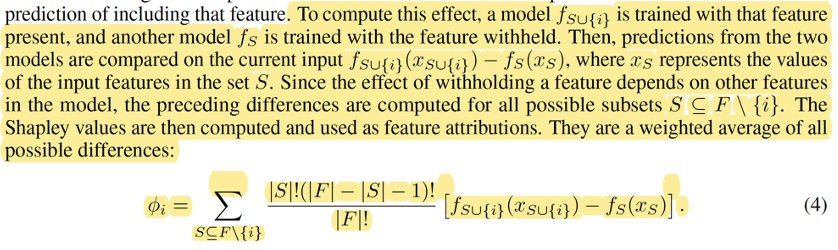

In [27]:
class_names = ["Non-Diabetic", "Pre-Diabetic", "Diabetic"]

# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_val)

# compute SHAP values on Test for Force plots 
shap_values_test = explainer.shap_values(X_test)

**Feature Importance Using SHAP**

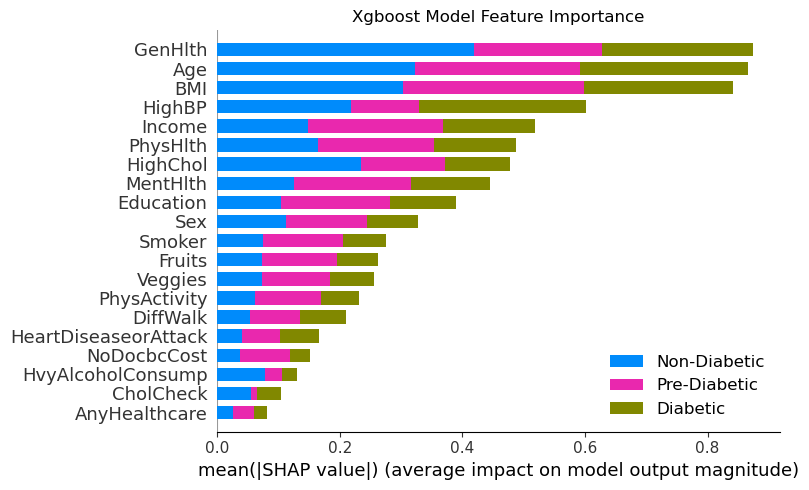

In [28]:
plt.figure(figsize=(8,6))
plt.title("Xgboost Model Feature Importance")
shap.summary_plot(shap_values, 
                  X_train_val.values, 
                  plot_type="bar", 
                  class_names=class_names,
                  feature_names = X_train_val.columns,
                  plot_size = (8,5))

**Insights**

- Feature Importance from SHAP is rigourous and take into consideration of change of multiple variable together not just constant shift of a feature value. And it iterates through large of samples for the SHAPly calculations and are consistent.
- GenHlth i.e. self reported health is given highest importance by the model which looks intuitive for all three classes roughly. 
- Age is the second important feature that model uses to distinguish between the three classes. We saw during EDA as higher age is high risk of being diabetic with bad life style. 
- BMI is also an important factor, visually it looks like BMI is most important for identifying pre-diabetic patients.
- HighBP visually looks most imporant feature for identifying diabetic patients according to model which was observent during the EDA as well.
- Features like education, mental healh, whether a person is smoker, person consuming fruits, veggies & physical activity have significantly high impact for identification of pre-diabetics prediction.
- Model has not given much importance to features like Difficulty in walking, whether a person is a heavy alcohol consumer
- Also person who encountered an hear attack is also not given mich importance by model. This is the result maybe because of less patients encountering heart attack in the data.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

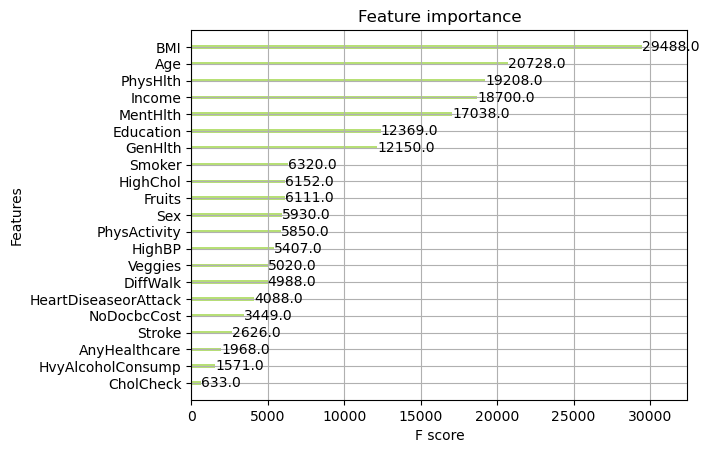

In [29]:
# Default feature importance plot by Xgboost
booster_xgb = model.get_booster()
xgb.plot_importance(booster_xgb)

**Note**

Relying on feature importances obtained from XGBoost is not reliable as they tend to vary across different types of calculations. It suggests observing how feature importances shift with the method of calculation.

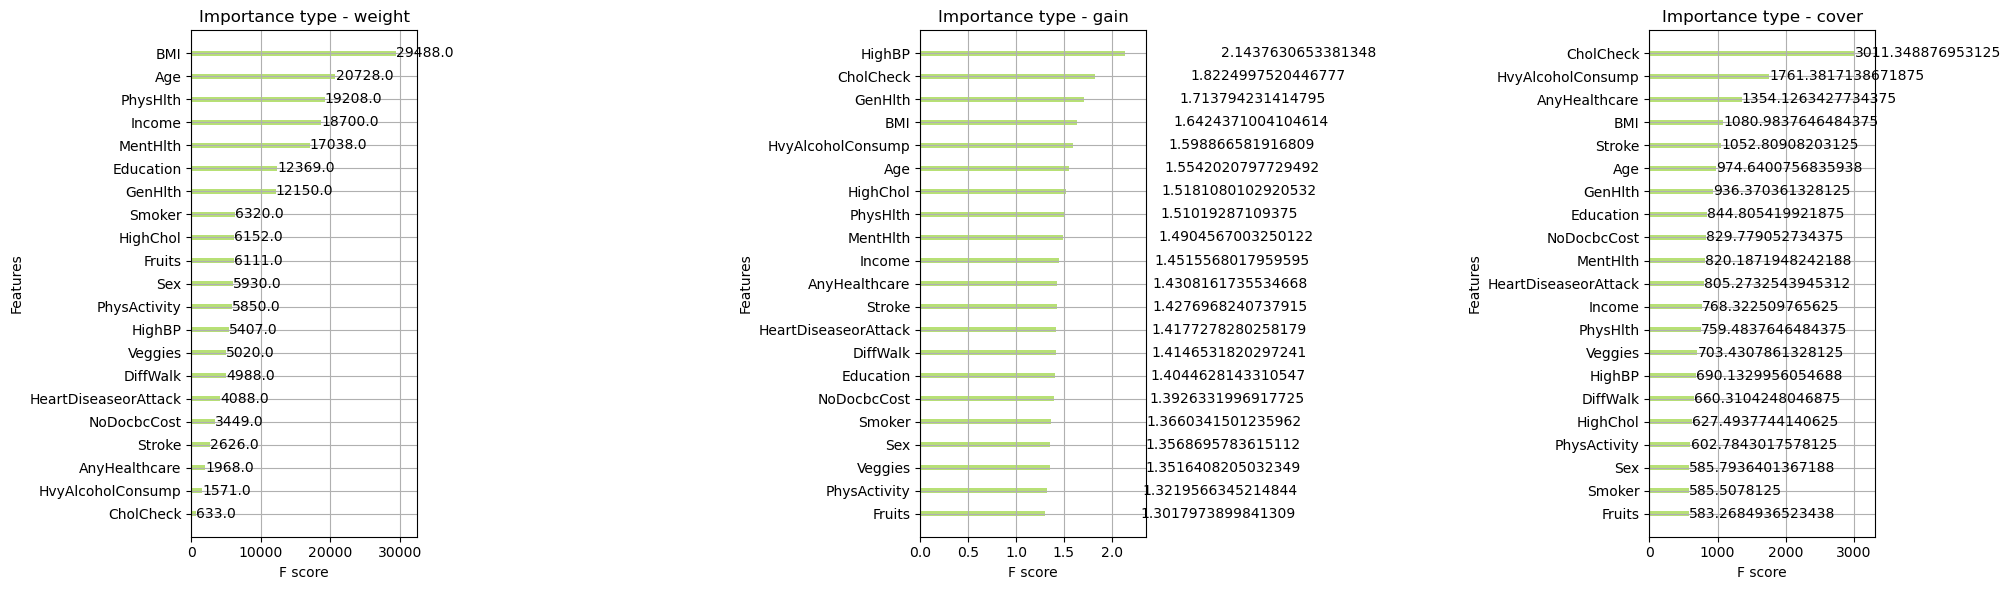

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, imp_type in zip(axes.flatten(), ["weight", "gain", "cover"]):
    xgb.plot_importance(
        booster_xgb,
        ax=ax,
        importance_type=imp_type,
        title=f"Importance type - {imp_type}",
    )

plt.tight_layout()
plt.show()


**Insight**

- We can clearly see the feature importance from Xgboost is not consistent given the way it is calculated.
- On the other hand, feature importances acquired through Shapley values are dependable and coherent. Furthermore, we won't limit our examination to this point. The previous graphs only consider the magnitude of significance, but we need to determine which features have positive or negative impacts on the model. To accomplish this, let's use the SHAP summary plot.

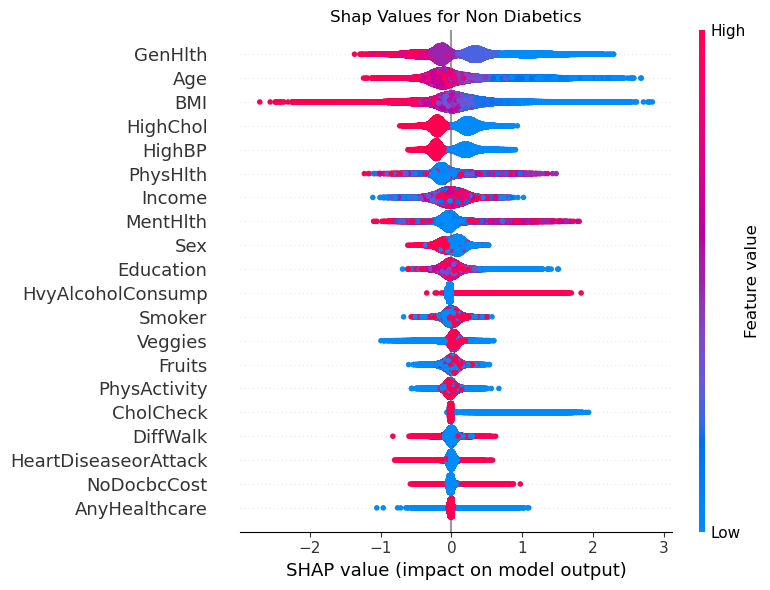

In [31]:
# call the shap.summary_plot() function for each class and pass the corresponding subplot
plt.title("Shap Values for Non Diabetics")
shap.summary_plot(shap_values[0], X_train_val.values, feature_names=X_train_val.columns, show=False, plot_size = (8,6))

**Insight**

- For model to predict a person has non diabetic lower values of genhlth feature (Good health), lower age, lower BMI, lower Cholestrol, No cholestrol check have significant affecting on pushing the SHAP values greater than average prediction. 
- While Higher BMI (obese), higher Age and bad health report tries to push back the value from predicting the person as non-diabetic

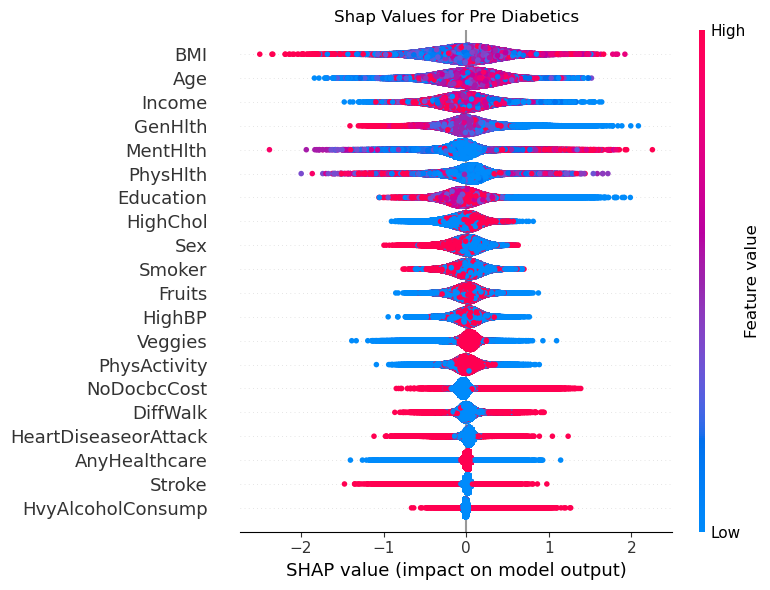

In [32]:
plt.title("Shap Values for Pre Diabetics")
shap.summary_plot(shap_values[1], X_train_val.values, feature_names=X_train_val.columns, show=False, plot_size = (8,6))

**Insight**

- The model has trouble in predicting the "pre-diabetic" class as we can see confusion in BMI, Age, Income, GenHlth, PhysHlth. But if we look closely very high BMI values might have both positive and negetive effect as model might push it being diabetic as well as "pre-diabetic".
- Lower age is seen to have lesser effect on predicting pre-diabetic.
- Bad Mental health condition pushes the SHAP towards being pre-diabetic.

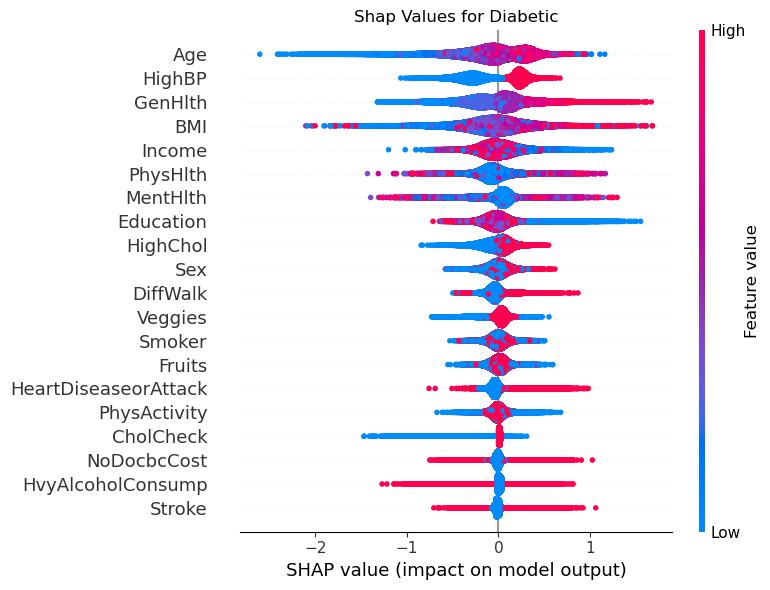

In [33]:
plt.title("Shap Values for Diabetic")
shap.summary_plot(shap_values[2], X_train_val.values, feature_names=X_train_val.columns, show=False,  plot_size = (8,6))

**Insight**

- Higher Age, High BP, High GenHlth value (Poor health), High BMI, Difficulty in walking, people with heart attach diseases increases the SHAP values and pushes the model to predict the person as diabetic
- Lower income, lower education increases the SHAP values and pushes the model to predict the person as diabetic
- Lower Age on the other significantly reduces the SHAP value and restricts it to predict the person as "Diabetic"

## SHAP - Dependence Plot

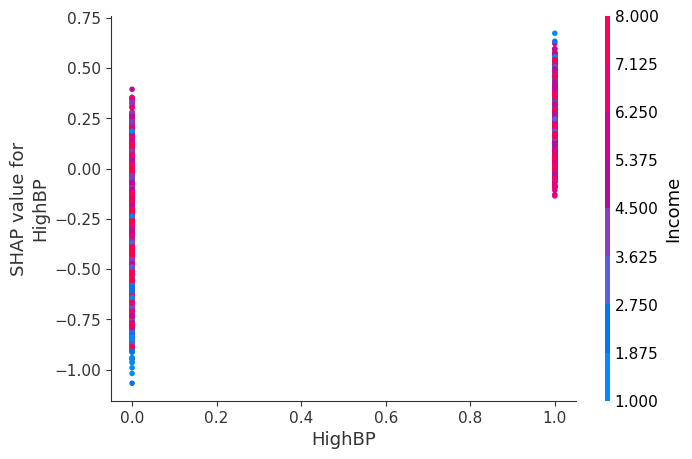

In [34]:
shap.dependence_plot(0, shap_values[2], X_train_val.values, feature_names=X_train_val.columns)

**Insight**

Higher BP has a linear replationship towards getting diabetic. High BP --> More chance of getting diabetic. It has have a association with HvyAlcohol Comsumption feature as well.

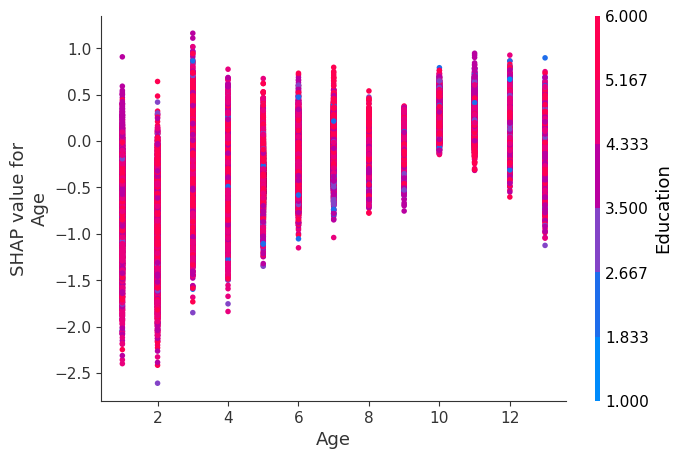

In [35]:
shap.dependence_plot(18, shap_values[2], X_train_val.values, feature_names=X_train_val.columns)

**Insight**

Higher Age has a slighly linear replationship towards getting diabetic. Higher Age It has have a strong association with Education feature as well.

# Local Interpretability

## Example on individual diabetic patient - Testdata - SHAP Force Plots

A force plot is a tool that helps us understand how a model made a specific prediction by showing the contribution of each feature to the prediction. It is useful for analyzing errors and gaining a better understanding of individual cases.

In [39]:
joined_df_test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True), pd.DataFrame(y_pred_test, columns = ["Prediction"]).reset_index(drop = True)], axis = 1)

In [40]:
diab_index = list(joined_df_test[(joined_df_test['Diabetes_012'] == joined_df_test['Prediction']) & (joined_df_test['Prediction']==2)].index)
diab_index[0:20]

[12,
 54,
 76,
 96,
 104,
 287,
 335,
 347,
 400,
 407,
 425,
 426,
 430,
 470,
 494,
 542,
 618,
 625,
 736,
 766]

In [41]:
shap.initjs()
i=12
class_val = 2
shap.force_plot(explainer.expected_value[class_val], shap_values_test[class_val][i], X_test.values[i], feature_names = X_test.columns)

In [42]:
i=766
class_val = 2
shap.force_plot(explainer.expected_value[class_val], shap_values_test[class_val][i], X_test.values[i], feature_names = X_test.columns)

In [43]:
i=407
class_val = 2
shap.force_plot(explainer.expected_value[class_val], shap_values_test[class_val][i], X_test.values[i], feature_names = X_test.columns)

## Further Drill down by Waterfall plot - SHAP Waterfall

The waterfall plot is another local analysis plot of a single instance prediction. This is a detailed way of representing the Force plots.

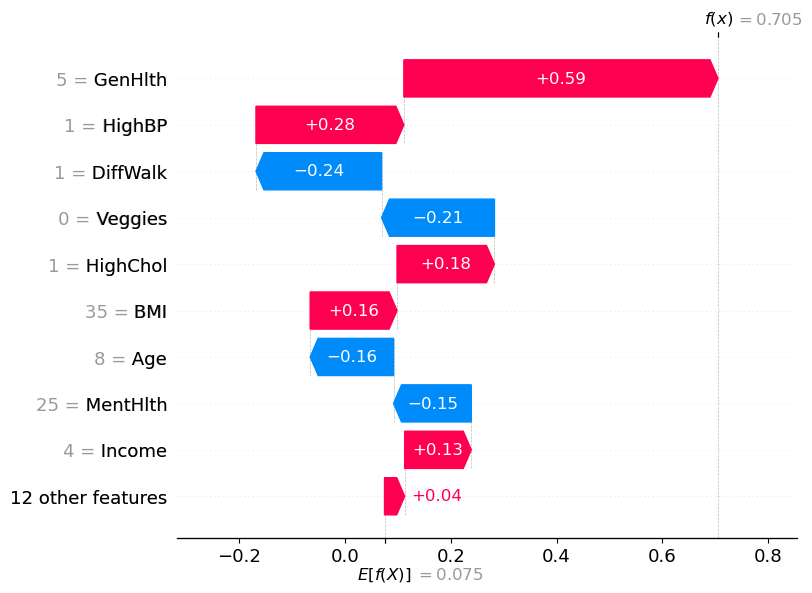

In [44]:
i=12
class_val = 2
shap.waterfall_plot(shap.Explanation(values=shap_values_test[class_val][i], 
                                            base_values=explainer.expected_value[class_val], data=X_test.iloc[i],  
                                            feature_names=X_test.columns.tolist()))

**Insight**

- Bad health reported by the person with high BP significantly pushes the average expected value for the pre diabetic class.
- Difficulting in walking, eating no veggies, lower age tries to reduces strength of model predicted SHAP for this person. This means all these factor might push him to the third class i.e. to being diabetic. This is what we can potray from this.

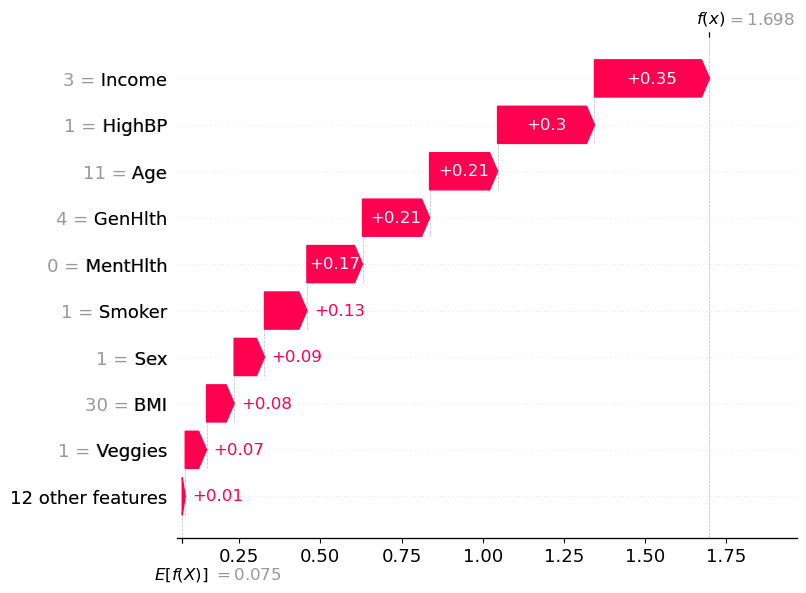

In [45]:
i=766
class_val = 2
shap.waterfall_plot(shap.Explanation(values=shap_values_test[class_val][i], 
                                            base_values=explainer.expected_value[class_val], data=X_test.iloc[i],  
                                            feature_names=X_test.columns.tolist()))

**Insight**

- As we can see, Being smoker, high age, high BMI, high BP lead to higher chances of model predicting the patient as Diabetic

## Example on individual Pre-diabetic patient - Testdata - SHAP Force Plots

In [46]:
diab_index = list(joined_df_test[(joined_df_test['Diabetes_012'] == joined_df_test['Prediction']) & (joined_df_test['Prediction']==1)].index)
diab_index

[6764, 17254, 22698, 26527, 35472]

In [47]:
i=17254
class_val = 1
shap.force_plot(explainer.expected_value[class_val], shap_values_test[class_val][i], X_test.values[i], feature_names = X_test.columns)

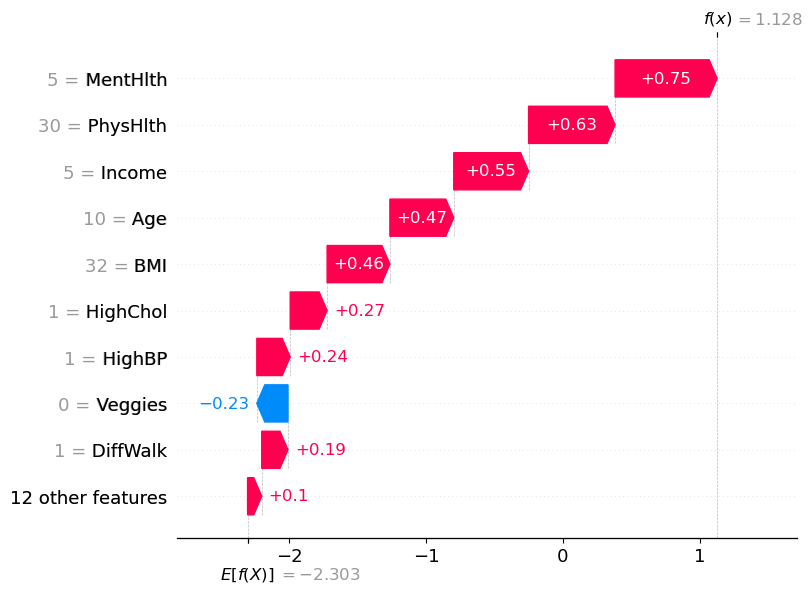

In [48]:
i=17254
class_val = 1
shap.waterfall_plot(shap.Explanation(values=shap_values_test[class_val][i], 
                                            base_values=explainer.expected_value[class_val], data=X_test.iloc[i],  
                                            feature_names=X_test.columns.tolist()))

**Key Insight**

As pre diabetic target count is less overall, for model to get trained on it, the average model prediction is negetive. Here are few things which we can get idea from SHAP. Person being in old age, having difficultly in walking, obese (high BMI), high cholestrol, bad mental health & physical health reported leds to a pre diabetic stage.

# LGBM Model

In [49]:
if loading_saved_model == True:
    # define objective function for Optuna
    def objective(trial):
        params = {
            "objective": "multiclass",
            "num_class": 3,
            "metric": "multi_logloss",
            "verbosity": -1,
            "n_jobs" : -1,
            "boosting_type": "gbdt",
            "random_state": 50,
            "max_depth": trial.suggest_int("max_depth", 1, 9),
            "subsample": trial.suggest_float("subsample", 0.1, 1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10),
            "n_estimators": trial.suggest_int("n_estimators", 50, 3000, step=50),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
            "device": "gpu",
            "gpu_platform_id": 0,
            "gpu_device_id": 0,
            "force_col_wise": True,
        }

        # use StratifiedKFold cross-validation with 5 folds
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

        # define F1 score as evaluation metric
        score = make_scorer(f1_score, average='macro')

        start_time = time.time()

        # perform cross-validation and calculate F1 score
        clf = lgb.LGBMClassifier(**params)
        early_stopping_rounds = 50
        clf.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                eval_metric='multi_logloss',
                early_stopping_rounds=early_stopping_rounds,
                verbose=False)
        y_pred = clf.predict(X_val)
        f1_score_val = f1_score(y_val, y_pred, average='macro')

        elapsed_time = time.time() - start_time

        # return mean F1 score and elapsed time
        return f1_score_val

    # create study object and optimize objective function
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    # print best hyperparameters and best F1 score
    print("Best hyperparameters: ", study.best_params)
    print("Best F1 score: ", study.best_value)

  0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters:  {'max_depth': 2, 'subsample': 0.4711696541347908, 'colsample_bytree': 0.14741760650520158, 'learning_rate': 0.24446118395728944, 'min_child_weight': 10, 'reg_alpha': 3.59349758523175, 'reg_lambda': 7.367895916060489, 'n_estimators': 1500, 'scale_pos_weight': 6.734803472317967}
Best F1 score:  0.4001386689991672


In [50]:
# Performance on test set and Overfitting check
model_lgbm = lgb.LGBMClassifier( objective = "multiclass",
             num_class = 3,
             metric = "multi_logloss",
             verbosity = -1,
             n_jobs = -1,
             boosting_type = 'gbdt', random_state=50, **study.best_params)
model_lgbm.fit(X_train, y_train)

y_pred_test = model_lgbm.predict(X_test)
f1_score_test = f1_score(y_test, y_pred_test, average='macro')

print("Validation F1-Score", study.best_value)
print("Test F1-Score", f1_score_test)
print("Difference between performance of Validation and test", abs(f1_score_test - study.best_value))
print(f"Is the Model Overfitting : {abs((f1_score_test - study.best_value))/ study.best_value > 0.05}")

Validation F1-Score 0.4001386689991672
Test F1-Score 0.399858027399654
Difference between performance of Validation and test 0.00028064159951324275
Is the Model Overfitting : False


Classification Report for LightGBM model on validation set

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91     30409
         1.0       0.00      0.00      0.00       740
         2.0       0.57      0.20      0.29      5616

    accuracy                           0.84     36765
   macro avg       0.47      0.39      0.40     36765
weighted avg       0.79      0.84      0.80     36765


 accuracy: 0.8364477084183326 & F1_Score: 0.400077078237066 

Classification Report for LightGBM model on hold out test set

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91     38012
         1.0       0.00      0.00      0.00       926
         2.0       0.57      0.19      0.29      7019

    accuracy                           0.84     45957
   macro avg       0.47      0.39      0.40     45957
weighted avg       0.79      0.84      0.80     45957


 accuracy: 0.8366951715734273 & F1_Score: 0.3998580

(array([[29652,     0,   757],
        [  656,     0,    84],
        [ 4516,     0,  1100]]),
 array([[37087,     0,   925],
        [  836,     0,    90],
        [ 5654,     0,  1365]]))

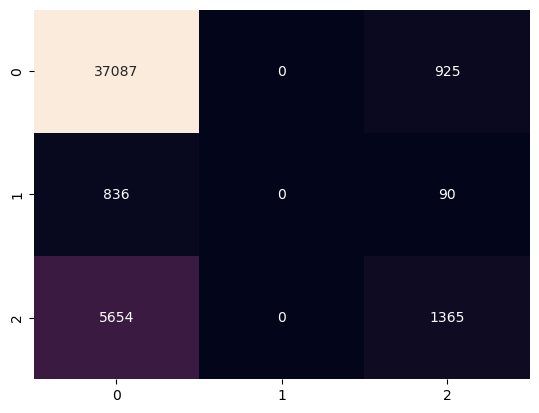

In [51]:
gen_class_report(model_lgbm,"LightGBM",X_val,y_val,X_test, y_test,val_skip = False)

In [52]:
# Performance on test set and Overfitting check
model_lgbm = lgb.LGBMClassifier( objective = "multiclass",
             num_class = 3,
             metric = "multi_logloss",
             verbosity = -1,
             n_jobs = -1,
             boosting_type = 'gbdt', random_state=50, **study.best_params)
model_lgbm.fit(X_train_val, y_train_val)

LGBMClassifier(colsample_bytree=0.14741760650520158,
               learning_rate=0.24446118395728944, max_depth=2,
               metric='multi_logloss', min_child_weight=10, n_estimators=1500,
               num_class=3, objective='multiclass', random_state=50,
               reg_alpha=3.59349758523175, reg_lambda=7.367895916060489,
               scale_pos_weight=6.734803472317967, subsample=0.4711696541347908,
               verbosity=-1)

Classification Report for LightGBM model on hold out test set

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91     38012
         1.0       0.00      0.00      0.00       926
         2.0       0.58      0.20      0.29      7019

    accuracy                           0.84     45957
   macro avg       0.48      0.39      0.40     45957
weighted avg       0.79      0.84      0.80     45957


 accuracy: 0.8375655504058142 & F1_Score: 0.4014311786149831 

Confusion matrix on test set : 



('',
 array([[37108,     0,   904],
        [  842,     0,    84],
        [ 5635,     0,  1384]]))

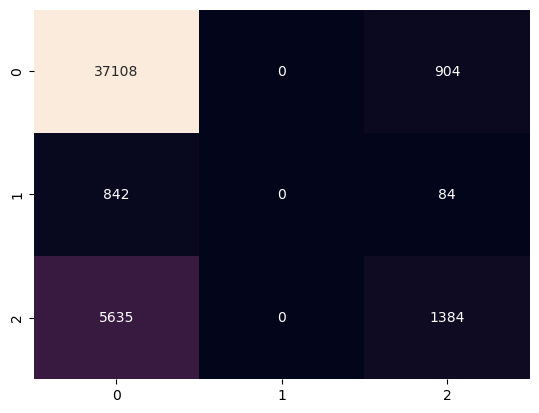

In [53]:
gen_class_report(model_lgbm,"LightGBM","","",X_test, y_test,val_skip = True)

In [54]:
class_names = ["Non-Diabetic", "Pre-Diabetic", "Diabetic"]

# compute SHAP values
explainer = shap.TreeExplainer(model_lgbm)
shap_values_lgbm = explainer.shap_values(X_train_val)

# compute SHAP values on Test for Force plots 
shap_values_test_lgbm = explainer.shap_values(X_test)

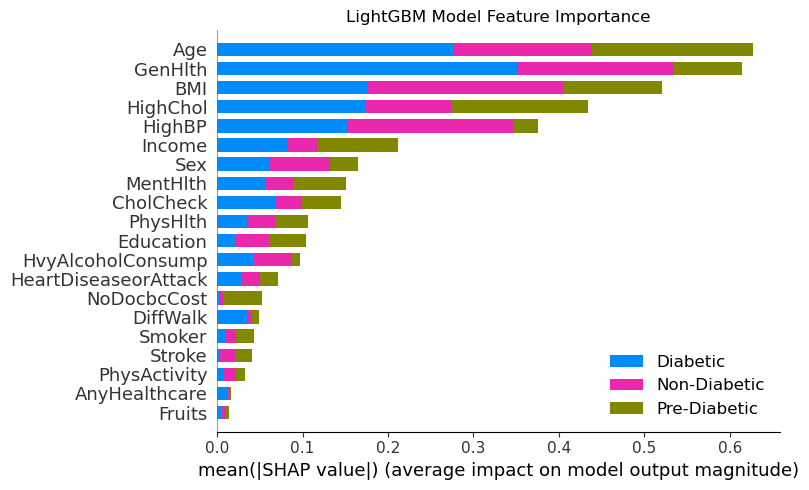

In [55]:
plt.figure(figsize=(8,6))
plt.title("LightGBM Model Feature Importance")
shap.summary_plot(shap_values_lgbm, 
                  X_train_val.values, 
                  plot_type="bar", 
                  class_names=class_names,
                  feature_names = X_train_val.columns,
                  plot_size = (8,5))

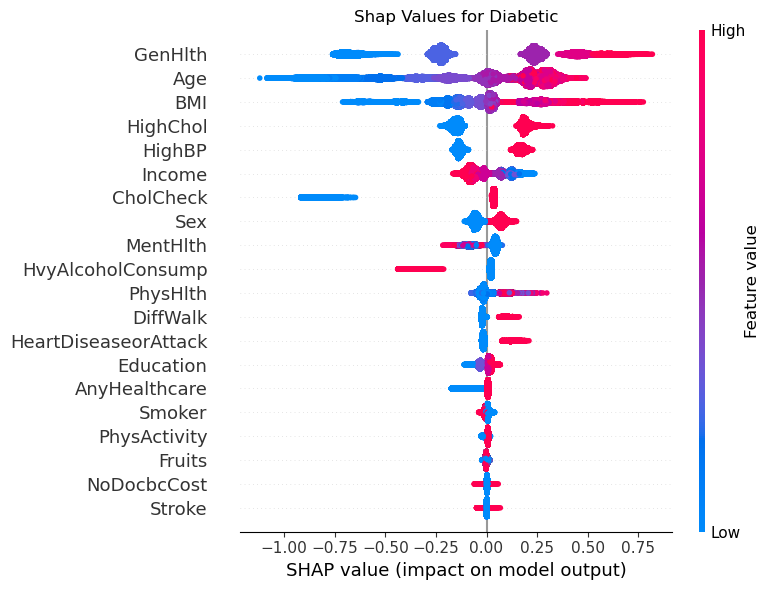

In [56]:
plt.title("Shap Values for Diabetic")
shap.summary_plot(shap_values_lgbm[2], X_train_val.values, feature_names=X_train_val.columns, show=False,  plot_size = (8,6))

# Undersampling for Model Performance Improvement

In [28]:
# Lets try ramdom undersampling, tomeklinks and clustercentroids undersampling techniques to see if we can improve model performance.
def undersampling_optimization(X_train, y_train, X_val, y_val, X_test, y_test):
    undersampling_techniques = {
        "RandomUnderSampler": RandomUnderSampler(random_state=0),
        "TomekLinks": TomekLinks(),
        "ClusterCentroids": ClusterCentroids(random_state=0)
    }

    results = []

    for technique_name, technique in undersampling_techniques.items():
        print(f"{'='*100}")
        print(f"Running modelling pipeline using {technique_name} Undersampling Technique")
        X_train_resampled, y_train_resampled = technique.fit_resample(X_train, y_train)

        # define objective function for Optuna
        def objective(trial):
            params = {
                "random_state" : 100,
                "objective": "multi:softmax",
                'verbosity': 0,
                "num_class": 3,
                "eval_metric": "mlogloss",
                "tree_method": "gpu_hist",
                "booster": "gbtree",
                "max_depth": trial.suggest_int("max_depth", 2, 12),
                "subsample": trial.suggest_float("subsample", 0.1, 1),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "gamma": trial.suggest_float("gamma", 0.01, 1),
                "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10),
                "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10),
                "n_estimators": trial.suggest_int("n_estimators", 50, 3000, step=50),
                "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
                "grow_policy": trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
            }
            # use StratifiedKFold cross-validation with 5 folds
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

            # define F1 score as evaluation metric
            score = make_scorer(f1_score, average='macro')

            start_time = time.time()

            # perform cross-validation and calculate F1 score
            clf = xgb.XGBClassifier(**params)
            clf.fit(X_train_resampled, y_train_resampled)
            y_pred = clf.predict(X_val)
            f1_score_val = f1_score(y_val, y_pred, average='macro')

            elapsed_time = time.time() - start_time

            # return mean F1 score and elapsed time
            return f1_score_val

        # create study object and optimize objective function
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=50, show_progress_bar=True)

        # print best hyperparameters and best F1 score
        print("Best hyperparameters: ", study.best_params)
        print("Best F1 score: ", study.best_value)

        # Performance on test set and Overfitting check
        model = xgb.XGBClassifier(objective="multi:softmax",
                                  random_state=100,
                                  verbosity=0,
                                  num_class=3,
                                  eval_metric="mlogloss",
                                  tree_method="gpu_hist",
                                  booster="gbtree", **study.best_params)
        model.fit(X_train_resampled, y_train_resampled)

        y_pred_test = model.predict(X_test)
        f1_score_test = f1_score(y_test, y_pred_test, average='macro')

        print("Validation F1-Score", study.best_value)
        print("Test F1-Score", f1_score_test)
        print("Difference between performance of Validation and test",
              abs(f1_score_test - study.best_value))
        print(
            f"Is the Model Overfitting : {abs((f1_score_test - study.best_value)) / study.best_value > 0.05}")

        results.append({
            "Undersampling Technique": technique_name,
            "Best Hyperparameters" : study.best_params,
            "Best Tuned F1 Score" : study.best_value,
            "Test F1 Score" : f1_score_test})
        
        print(f"{'='*100}")
        
    df_results = pd.DataFrame(results)
    # rank the models by "Best Tuned F1 Score" in descending order
    df_results["Rank"] = df_results["Best Tuned F1 Score"].rank(method='dense', ascending=False)

    # sort the dataframe by rank
    df_results = df_results.sort_values(by=["Rank"])
        
    return (df_results, results)


In [29]:
undersampling_results = undersampling_optimization(X_train, y_train, X_val, y_val, X_test, y_test)

Running modelling pipeline using RandomUnderSampler Undersampling Technique


  0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters:  {'max_depth': 3, 'subsample': 0.20777156990903003, 'colsample_bytree': 0.215459116861062, 'learning_rate': 0.0732043656488762, 'min_child_weight': 7, 'gamma': 0.9590135715814948, 'reg_alpha': 6.493389217500314, 'reg_lambda': 0.7476437696792751, 'n_estimators': 100, 'scale_pos_weight': 5.181355844601924, 'grow_policy': 'depthwise'}
Best F1 score:  0.42390145131069784
Validation F1-Score 0.42390145131069784
Test F1-Score 0.4306511583817853
Difference between performance of Validation and test 0.006749707071087463
Is the Model Overfitting : False
Running modelling pipeline using TomekLinks Undersampling Technique


  0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters:  {'max_depth': 9, 'subsample': 0.22935092182649244, 'colsample_bytree': 0.8799477392245763, 'learning_rate': 0.24906878757676024, 'min_child_weight': 2, 'gamma': 0.44656633041187277, 'reg_alpha': 0.502217281648315, 'reg_lambda': 5.555871731560165, 'n_estimators': 2100, 'scale_pos_weight': 4.282233503589769, 'grow_policy': 'depthwise'}
Best F1 score:  0.4105515674525855
Validation F1-Score 0.4105515674525855
Test F1-Score 0.40432967968408273
Difference between performance of Validation and test 0.006221887768502743
Is the Model Overfitting : False
Running modelling pipeline using ClusterCentroids Undersampling Technique


  0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters:  {'max_depth': 8, 'subsample': 0.3387623139119683, 'colsample_bytree': 0.33037171710066054, 'learning_rate': 0.28206405488756686, 'min_child_weight': 7, 'gamma': 0.2968602626125298, 'reg_alpha': 0.8092071792621303, 'reg_lambda': 4.322106984362857, 'n_estimators': 2800, 'scale_pos_weight': 7.0912233239229625, 'grow_policy': 'depthwise'}
Best F1 score:  0.03515975911186915
Validation F1-Score 0.03515975911186915
Test F1-Score 0.03572201491276015
Difference between performance of Validation and test 0.000562255800890997
Is the Model Overfitting : False


**Lets see the leaderboard**

In [30]:
undersampling_results[0]

Undersampling Technique                               Best Hyperparameters  \
0      RandomUnderSampler  {'max_depth': 3, 'subsample': 0.20777156990903...   
1              TomekLinks  {'max_depth': 9, 'subsample': 0.22935092182649...   
2        ClusterCentroids  {'max_depth': 8, 'subsample': 0.33876231391196...   

   Best Tuned F1 Score  Test F1 Score  Rank  
0             0.423901       0.430651   1.0  
1             0.410552       0.404330   2.0  
2             0.035160       0.035722   3.0

In [54]:
best_param = results_df[results_df['Rank']==1]['Best Hyperparameters'][0]
print(best_param)

{'max_depth': 3, 'subsample': 0.20777156990903003, 'colsample_bytree': 0.215459116861062, 'learning_rate': 0.0732043656488762, 'min_child_weight': 7, 'gamma': 0.9590135715814948, 'reg_alpha': 6.493389217500314, 'reg_lambda': 0.7476437696792751, 'n_estimators': 100, 'scale_pos_weight': 5.181355844601924, 'grow_policy': 'depthwise'}


In [31]:
# Fitting model after using ramdomundersampler and the best param from optuna as our final model
ros = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

results_df = undersampling_results[0].copy()



model = xgb.XGBClassifier( objective = "multi:softmax",
                             random_state=50,
                             verbosity =  0,
                             num_class = 3,
                             eval_metric = "mlogloss",
                             tree_method = "gpu_hist",
                             booster = "gbtree", **best_param)
model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.215459116861062, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              gamma=0.9590135715814948, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0732043656488762, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', random_state=50, ...)

In [35]:
loading_saved_model = False

Classification Report for XGboost model on validation set

              precision    recall  f1-score   support

         0.0       0.94      0.66      0.77     30409
         1.0       0.03      0.22      0.05       740
         2.0       0.35      0.62      0.45      5616

    accuracy                           0.64     36765
   macro avg       0.44      0.50      0.42     36765
weighted avg       0.83      0.64      0.71     36765


 accuracy: 0.6414252685978512 & F1_Score: 0.4233342418534584 

Classification Report for XGboost model on hold out test set

              precision    recall  f1-score   support

         0.0       0.94      0.66      0.78     38012
         1.0       0.03      0.25      0.06       926
         2.0       0.36      0.62      0.45      7019

    accuracy                           0.65     45957
   macro avg       0.44      0.51      0.43     45957
weighted avg       0.83      0.65      0.71     45957


 accuracy: 0.649041495310834 & F1_Score: 0.430133152

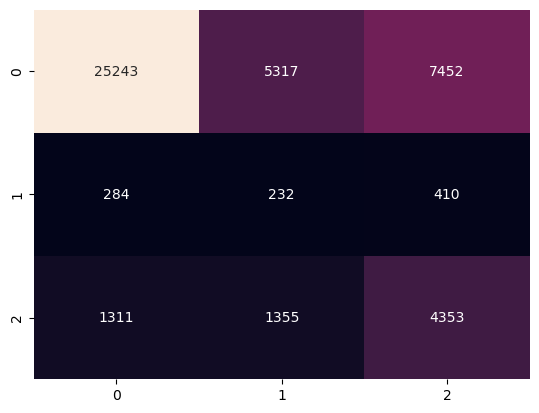

In [36]:
if loading_saved_model == False:
    gen_class_report(model,"XGboost",X_val,y_val,X_test, y_test,val_skip = False)

We can see that using undersampling we improved the f1-score for prediction of pre-diabetic as well as diabetic patients. Also we are drastically able to improve the recall for the minority class as well with improvement in overall f1-score on the test datra. Hence lets use this model as our champion model to recalculate SHAP.

# SHAP after Undersampling

The plots below looks better and help us understand how features affect the target in a more robust way.

I will leave the interpretation for you to think of, dont worry it will be easy for you !!

In [37]:
class_names = ["Non-Diabetic", "Pre-Diabetic", "Diabetic"]

# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_resampled)

# compute SHAP values on Test for Force plots 
shap_values_test = explainer.shap_values(X_test)


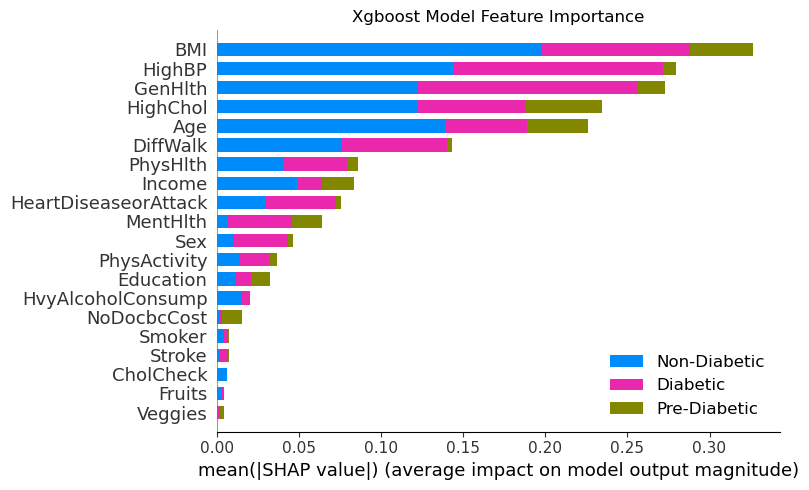

In [38]:
plt.figure(figsize=(8,6))
plt.title("Xgboost Model Feature Importance")
shap.summary_plot(shap_values, 
                  X_train_val.values, 
                  plot_type="bar", 
                  class_names=class_names,
                  feature_names = X_train_val.columns,
                  plot_size = (8,5))

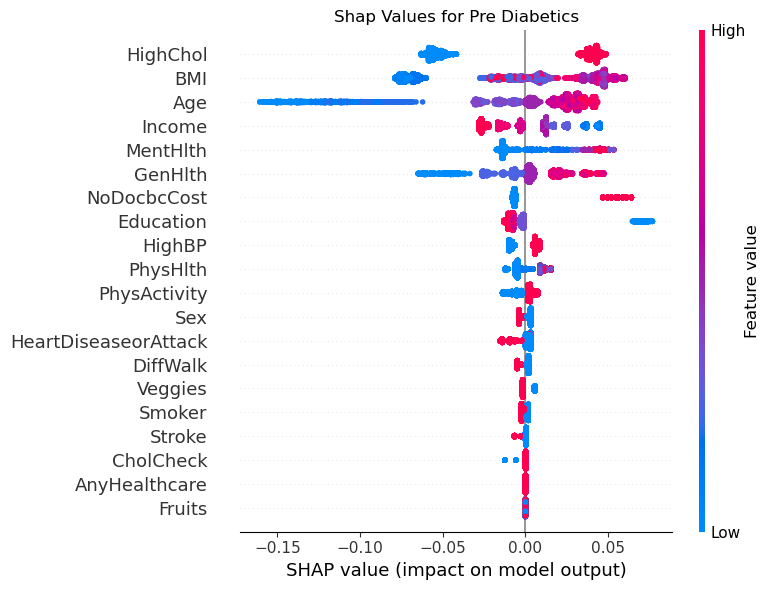

In [52]:
# call the shap.summary_plot() function for each class and pass the corresponding subplot
plt.title("Shap Values for Pre Diabetics")
shap.summary_plot(shap_values[1], X_train_resampled.values, feature_names=X_train_resampled.columns, show=False, plot_size = (8,6))

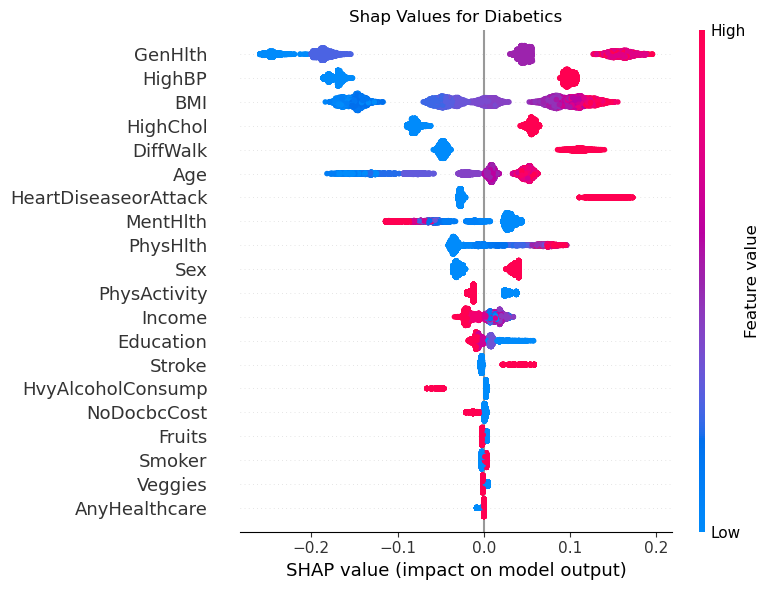

In [53]:
# call the shap.summary_plot() function for each class and pass the corresponding subplot
plt.title("Shap Values for Diabetics")
shap.summary_plot(shap_values[2], X_train_resampled.values, feature_names=X_train_resampled.columns, show=False, plot_size = (8,6))

**Insight**

The seperation looks more prominent in this model with less overlapping. 

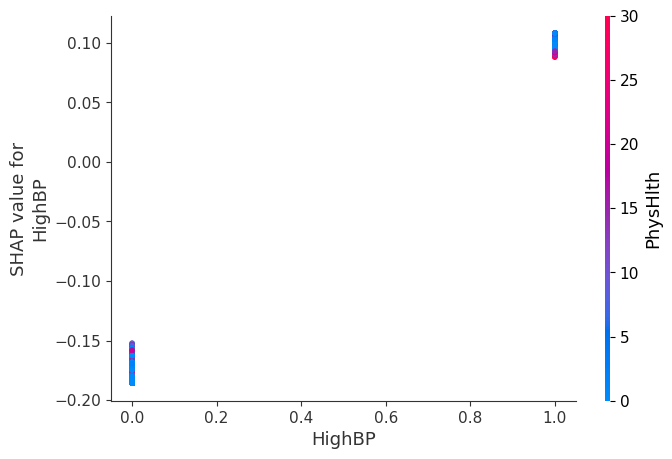

In [41]:
shap.dependence_plot(0, shap_values[2], X_train_resampled.values, feature_names=X_train_resampled.columns)

In [43]:
y_pred_test = model.predict(X_test)
joined_df_test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True), pd.DataFrame(y_pred_test, columns = ["Prediction"]).reset_index(drop = True)], axis = 1)

In [44]:
diab_index = list(joined_df_test[(joined_df_test['Diabetes_012'] == joined_df_test['Prediction']) & (joined_df_test['Prediction']==2)].index)
diab_index[0:20]

[0,
 12,
 52,
 54,
 58,
 73,
 76,
 93,
 96,
 104,
 111,
 141,
 148,
 162,
 167,
 171,
 185,
 238,
 250,
 258]

In [45]:
shap.initjs()
i=0
class_val = 2
shap.force_plot(explainer.expected_value[class_val], shap_values_test[class_val][i], X_test.values[i], feature_names = X_test.columns)

In [46]:
shap.initjs()
i=12
class_val = 2
shap.force_plot(explainer.expected_value[class_val], shap_values_test[class_val][i], X_test.values[i], feature_names = X_test.columns)

In [48]:
diab_index = list(joined_df_test[(joined_df_test['Diabetes_012'] == joined_df_test['Prediction']) & (joined_df_test['Prediction']==1)].index)
diab_index[0:20]

[84,
 707,
 799,
 1179,
 1217,
 1602,
 1828,
 1939,
 2084,
 2124,
 2144,
 2581,
 2922,
 3057,
 3184,
 3323,
 3848,
 4222,
 4468,
 4572]

In [51]:
shap.initjs()
i=799
class_val = 1
shap.force_plot(explainer.expected_value[class_val], shap_values_test[class_val][i], X_test.values[i], feature_names = X_test.columns)

**Insights**

This model has a high base value for pre diabetic class which is very low in count through undersampling and gives us an estimate of how features help the model in predicting pre diabetic patients.

# Conclusion

In conclusion, SHAP is a Python library that provides a powerful and flexible way to interpret machine learning models and understand how they make their predictions. By computing feature importance scores based on Shapley values, SHAP can provide valuable insights into the contribution of each feature to a given prediction, and help you identify which features are most important for your model's performance. Whether you are building a model for diabetics diagnosis, credit card acceptibility model or any other task, SHAP can be a valuable tool for improving your understanding of how your model works and identifying areas for improvement.

If you like my kernel do upvote and add comments in the comment section, will love to solve any query you have.

![](https://www.reactiongifs.com/r/2013/02/murray_upvote.gif)